# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)

# Root directory of the project
ROOT_DIR = os.path.abspath("..\\..\\")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class SyntheticSugarbeetsConfig(Config):
    """Configuration for training on the Synthetic Sugarbeets dataset.
    Derives from the base Config class and overrides values specific
    to the Sythetic Sugarbeets dataset.
    """
    # Give the configuration a recognizable name
    NAME = "SyntheticSugarbeets"

    # Train on 1 GPU and 1800 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is ?? (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #40,000 max

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 plants

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    #VALIDATION_STEPS = 5
    
config = SyntheticSugarbeetsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class SyntheticSugarbeetsDataset(utils.Dataset):
    """Generates the synthetic sugarbeet dataset."""

    def load_SyntheticSugarbeets(self, count, width, height, folder, seed, purpose):
        """Load the requested number of synthetic images.
        count: number of images to generate.
        """
        # Add classes
        self.add_class("SyntheticSugarbeets", 1, "Sugarbeat")
        self.add_class("SyntheticSugarbeets", 2, "Capsella")
        self.add_class("SyntheticSugarbeets", 3, "Galium")
        
        trainfilepath = os.path.join(folder, 'train1.txt')
        my_file = open(trainfilepath, "r")
        contents = my_file.read().splitlines()
        my_file.close()
        image_filepaths = []
        for tail in contents:
            image_filepaths.append(os.path.join(os.path.join(folder, 'rgb'), tail))
        
        if purpose == 'train':
            sampled_image_filepaths = image_filepaths[:count]
        else:
            sampled_image_filepaths = image_filepaths[-count:]
        
        for i in range(count):
            self.add_image("SyntheticSugarbeets", image_id=i, path=sampled_image_filepaths[i],
                           width=width, height=height)

            
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        info = self.image_info[image_id]
        image = cv2.imread(info['path'])
        resized_image_results = utils.resize_image(image, max_dim=info['width'], mode="square")
        self.image_info[image_id].update(scale=resized_image_results[2], padding=resized_image_results[3])
        return cv2.cvtColor(resized_image_results[0], cv2.COLOR_BGR2RGB)

            
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        img_path = info['path']
        head,tail = os.path.split(img_path)
        instance_path = head[:-3]+"instance_mask\\"+tail
        lbl_path = head[:-3]+"label\\"+tail
        instance_mask = cv2.imread(instance_path,cv2.IMREAD_GRAYSCALE)
        lbl = cv2.imread(lbl_path,cv2.IMREAD_GRAYSCALE)
        count = np.max(instance_mask)
        
        mask = np.zeros([np.shape(instance_mask)[0], np.shape(instance_mask)[1], count], dtype=np.bool)
        class_ids = np.zeros(count,dtype=np.int32)
        for i in range(count):
            mask[:, :, i] = instance_mask == (i+1)
            class_ids[i] = np.max(np.multiply(mask[:, :, i].astype('uint8'),lbl))
        
        mask = utils.resize_mask(mask, scale=info['scale'], padding=info['padding'])
        return mask, class_ids

In [5]:
# Training dataset
dataset_train = SyntheticSugarbeetsDataset()
FOLDER = ".\\data\\occlusion_00\\"
dataset_train.load_SyntheticSugarbeets(1600, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1],FOLDER,seed=123,purpose='train')
dataset_train.prepare()

# Validation dataset
dataset_val = SyntheticSugarbeetsDataset()
dataset_val.load_SyntheticSugarbeets(290, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1],FOLDER,seed=123,purpose='validation')
dataset_val.prepare()

## Create Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


In [7]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [8]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
#model.train(dataset_train, dataset_val, 
#            learning_rate=config.LEARNING_RATE, 
#            epochs=5, 
#            layers='heads')

In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
#model.train(dataset_train, dataset_val, 
#            learning_rate=config.LEARNING_RATE / 10,
#            epochs=15, 
#            layers="all")

In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
#model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
#model.keras_model.save_weights(model_path)

## Detection

In [11]:
class InferenceConfig(SyntheticSugarbeetsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "logs\\syntheticsugarbeets_occlusion30\\mask_rcnn_syntheticsugarbeets_0015.h5")
#model_path = model.find_last()[0]
#
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  D:\TAMU\Mask_RCNN\logs\syntheticsugarbeets_occlusion30\mask_rcnn_syntheticsugarbeets_0015.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  159.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  512.00000  int32
gt_class_id              shape: (12,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (12, 4)               min:   25.00000  max:  494.00000  int32
gt_mask                  shape: (512, 512, 12)        min:    0.00000  max:    1.00000  bool


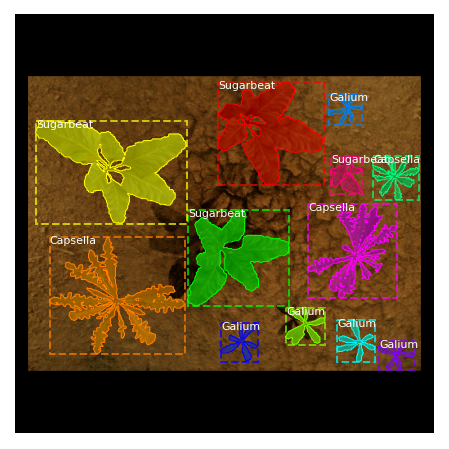

In [12]:
# Test on a random image
image_id = dataset_val.image_ids[0]
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

#gt_class_id -= 1
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  159.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   35.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32





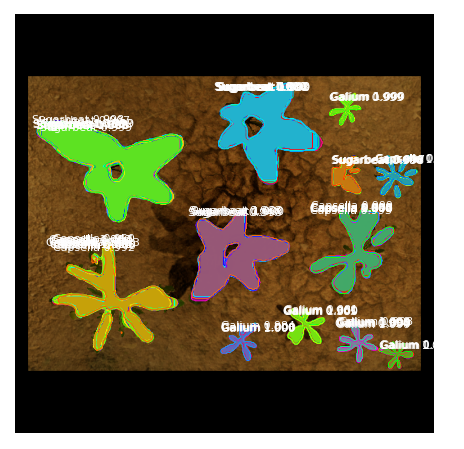

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax(), show_bbox=False)

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8124505661724002
